# Final Project Clara Schlösser

# Background and project objective

There is a growing need for menatal heatlth awarness and recources at the workplace. Modern workplaces also in the Tech shpere are trying to plan these recources. The aim of this projet is to try wether it is possible to predict wheter an idividual did receive counceling on the basis of other variables such as gender and other question surrounding the workplace enviorment. 

## 1.1 Data Source

The dataset is from a 2014 survey that measures attitudes towards mental health and frequency of mental health disorders in the tech workplace.

Source: https://osmihelp.org/research

|Questions|Key|
|:---------------------------------------|:----------------:|
|Are you self-employed?|self_employed|
|Do you have a family history of mental illness?|family_history|
|Have you sought treatment for a mental health condition?|treatment|
|If you have a mental health condition, do you feel that it interferes with your work?|work_interfere|
|How many employees does your company or organization have?|no_employees|
|Do you work remotely (outside of an office) at least 50% of the time?|remote_work|
|Is your employer primarily a tech company/organization?|tech_company|
|Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?|anonymity|
|How easy is it for you to take medical leave for a mental health condition?|leave|
|Do you think that discussing a mental health issue with your employer would have negative consequences?|mental_health_consequence|
|Do you think that discussing a physical health issue with your employer would have negative consequences?|phys_health_consequence|
|Would you be willing to discuss a mental health issue with your coworkers?|coworkers|
|Would you be willing to discuss a mental health issue with your direct supervisor(s)?|supervisor|
|Would you bring up a mental health issue with a potential employer in an interview?|mental_health_interview|
|Would you bring up a physical health issue with a potential employer in an interview?|phys_health_interview|
|Do you feel that your employer takes mental health as seriously as physical health?|mental_vs_physical|
|Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?|obs_consequence|
|Does your employer provide mental health benefits?|benefits|
|Do you know the options for mental health care your employer provides?|care_options|
|Has your employer ever discussed mental health as part of an employee wellness program?|wellness_program|
|Does your employer provide resources to learn more about mental health issues and how to seek help?|seek_help|
|Any additional notes or comments|comments|

# 2. Realisation

## 2.1 Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

from scipy import stats
from scipy.stats import randint

## 2.2 Loading data

In [2]:
health_data = pd.read_csv('mental_health_data_2014.csv')

#remove unused colums
health_data = health_data.drop(['comments'], axis= 1)
health_data = health_data.drop(['state'], axis= 1)
health_data = health_data.drop(['Timestamp'], axis= 1)

print("data row count:",health_data.shape)

data row count: (1259, 24)


## 2.3 Cleaning data

In [3]:
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in health_data:
    if feature in intFeatures:
        health_data[feature] = health_data[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        health_data[feature] = health_data[feature].fillna(defaultString)
    elif feature in floatFeatures:
        health_data[feature] = health_data[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
health_data.head(5)  

# Clean unserious enteries


# Get names of indexes for which column Age has unserious enteries
indexNames = health_data[ health_data['Age'] == (-1726,-29,-1,99999999999) ].index
 
# Delete these row indexes from dataFrame
health_data.drop(indexNames , inplace=True)

## 2.4 Create gender groups

In [4]:
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in health_data.iterrows():

    if str.lower(col.Gender) in male_str:
        health_data['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        health_data['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        health_data['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
health_data = health_data[~health_data['Gender'].isin(stk_list)]

print(health_data['Gender'].unique())

['female' 'male' 'trans']


## 2.5 Complete missing age with mean

In [5]:
health_data['Age'].fillna(health_data['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(health_data['Age'])
s[s<18] = health_data['Age'].median()
health_data['Age'] = s
s = pd.Series(health_data['Age'])
s[s>120] = health_data['Age'].median()
health_data['Age'] = s

#Ranges of Age
health_data['age_range'] = pd.cut(health_data['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

## 2.6 Correct data

In [6]:
#Only 0.014% of self employed - change NaN to NOT self_employed and replace "NaN" string from defaultString
health_data['self_employed'] = health_data['self_employed'].replace([defaultString], 'No')
print(health_data['self_employed'].unique())

['No' 'Yes']


In [7]:
#Only 0.20% of self work_interfere - change NaN to "Don't know"and replace "NaN" string from defaultString

health_data['work_interfere'] = health_data['work_interfere'].replace([defaultString], 'Don\'t know' )
print(health_data['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


## 2.7 Encoding data

In [8]:
labelDict = {}
for feature in health_data:
    le = preprocessing.LabelEncoder()
    le.fit(health_data[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    health_data[feature] = le.transform(health_data[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
health_data = health_data.drop(['Country'], axis= 1)
health_data.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


# 3. Covariance Matrix

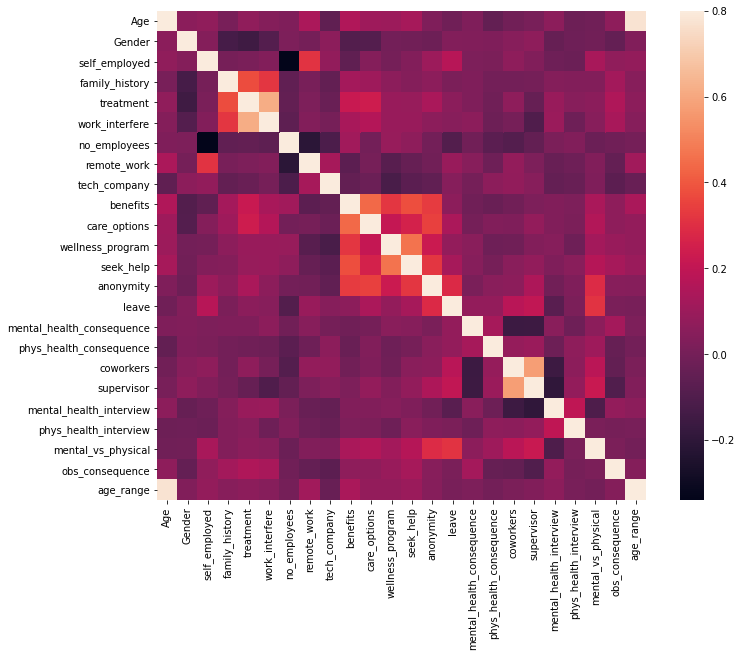

In [10]:
#correlation matrix
corrmat = health_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

# 4. Example of relation

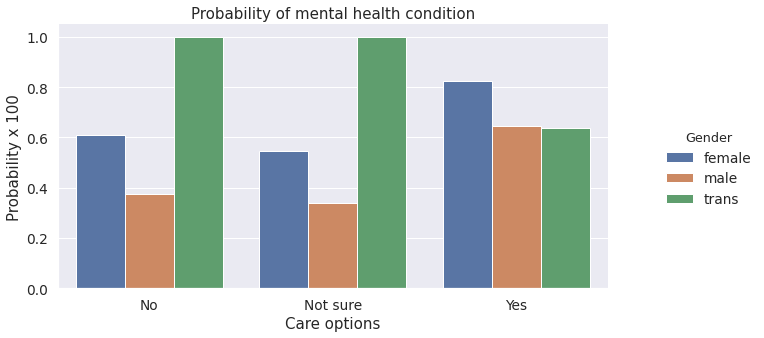

In [12]:
o = labelDict['label_care_options']
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=health_data, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')
# Legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# Positioning
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

# 5. prediction

As a model to predict wheter the worker received former mental health counceling the random forrest method was choosen in order to prevent overfitting. The final decision for random forrest was made on the basis of testing various models on the basisis of their accuracy score. Because the main focus was made to acheive good prediction the drawbacks of the Random forrest method, such as difficult interpretation were accepted.

## 5.1 Select dataset for the prediction

In [13]:
scaler = MinMaxScaler()
health_data['Age'] = scaler.fit_transform(health_data[['Age']])

feature_cols = ['Age', 'Gender', 'benefits', 'care_options', 'leave', 'work_interfere', 'anonymity']
X = health_data[feature_cols]
y = health_data.treatment

In [14]:
#Show feature_cols
X

,Age,Gender,benefits,care_options,leave,work_interfere,anonymity
0,0.431818,0,2,1,2,2,2
1,0.590909,1,0,0,0,3,0
2,0.318182,1,1,0,1,3,0
3,0.295455,1,1,2,1,2,1
4,0.295455,1,2,0,0,1,0
...,...,...,...,...,...,...,...
1254,0.181818,1,1,0,2,0,0
1255,0.318182,1,2,2,1,2,2
1256,0.363636,1,2,2,1,4,0
1257,0.636364,0,1,2,0,0,0


## 5.2 Show dataset


In [15]:
#show treatment
y

0       1
1       0
2       0
3       1
4       0
       ..
1254    1
1255    1
1256    1
1257    0
1258    1
Name: treatment, Length: 1257, dtype: int64

## 5.3 Make test-set

In [16]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

## 5.4 Random Forest

In [17]:
# Calculating the best parameters
forest = RandomForestClassifier(n_estimators = 20)

featuresSize = feature_cols.__len__()
param_dist = {"max_depth": [3, None],
          "max_features": randint(1, featuresSize),
          "min_samples_split": randint(2, 9),
          "min_samples_leaf": randint(1, 9),
          "criterion": ["gini", "entropy"]}

# Building and fitting my_forest
forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
my_forest = forest.fit(X_train, y_train)

# make predictions for the testing set
y_pred = my_forest.predict(X_test)

## 5.5 Output

In [18]:
#Classification accuracy: percentage of correct predictions
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8095238095238095


In [19]:
#Null accuracy: accuracy that could be achieved by always predicting the most frequent class
# examine the class distribution of the testing set (using a Pandas Series method)
print('Null accuracy:\n', y_test.value_counts())

Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64


In [20]:
# calculate the percentage of ones
print('Percentage of ones:', y_test.mean())

Percentage of ones: 0.4947089947089947


In [21]:
# calculate the percentage of zeros
print('Percentage of zeros:',1 - y_test.mean())

Percentage of zeros: 0.5052910052910053


In [22]:
#Comparing the true and predicted response values
print('True:', y_test.values[0:25])
print('Pred:', y_pred[0:25])

True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


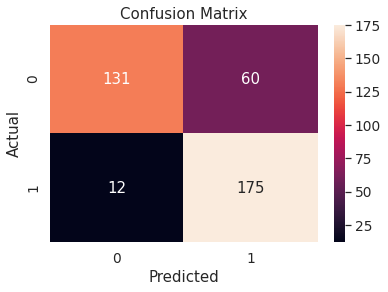

In [23]:
#Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# visualize Confusion Matrix
sns.heatmap(confusion,annot=True,fmt="d") 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
#Metrics computed from a confusion matrix - how often is the classifier correct?
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Classification Accuracy:', accuracy)

Classification Accuracy: 0.8095238095238095


In [25]:
#Classification Error: Overall, how often is the classifier incorrect?
print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred))

Classification Error: 0.19047619047619047


In [26]:
#False Positive Rate: When the actual value is negative - how often is the prediction incorrect?
false_positive_rate = FP / float(TN + FP)
print('False Positive Rate:', false_positive_rate)

False Positive Rate: 0.31413612565445026


In [27]:
#Precision: When a positive value is predicted, how often is the prediction correct?
print('Precision:', metrics.precision_score(y_test, y_pred))
print('AUC Score:', metrics.roc_auc_score(y_test, y_pred))

Precision: 0.7446808510638298
AUC Score: 0.8108463756754486


In [28]:
# calculate cross-validated AUC
print('Cross-validated AUC:', cross_val_score(my_forest, X, y, cv=10, scoring='roc_auc').mean())

Cross-validated AUC: 0.8820412982621363


In [29]:
#lassification threshold - the first 10 predicted responses
print('First 10 predicted responses:\n', my_forest.predict(X_test)[0:10])

First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]


In [33]:
# predict treatment if the predicted probability is greater than 0.3
y_pred_prob = y_pred_prob.reshape(-1,1) 
y_pred = binarize(y_pred_prob, 0.3)[0]

# print the first 10 predicted probabilities
print('First 10 predicted probabilities:\n', y_pred_prob[0:10])

First 10 predicted probabilities:
 [[0.63359407]
 [0.05391929]
 [0.08915247]
 [0.16635837]
 [0.66420429]
 [0.79846905]
 [0.18742041]
 [0.71933702]
 [0.78807633]
 [0.8983241 ]]


## 5.6 Creating predictions for the whole data set with the trained model


In [37]:
y_pred = my_forest.predict(X)

print ("The first colum is the index of the dataset")
results = pd.DataFrame({'Treatment': y, 'Prediction': y_pred})
#write result to CSV file
results.to_csv('results.csv', index=False)
results.head(10)


The first colum is the index of the dataset


,Treatment,Prediction
0,1,1
1,0,1
2,0,1
3,1,1
4,0,0
5,0,1
6,1,1
7,0,0
8,1,1
9,0,0


# 6 Conclusion

As a beginner I think over 80% of success with the model random forest is a good rate,
given the point is to know whether a worker sought treatment or not.